https://medium.com/@hasithsura/audio-classification-d37a82d6715

In [146]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt

In [38]:
folder_path = 'C:/native_language/wav/'

In [39]:
wav, sr = librosa.load(folder_path+'train_0001.wav', sr=None)
print(f'Sampling rate of the audio is {sr} Hz and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 16000 Hz and length of the audio is 46.8 seconds


In [96]:
wav.shape

(748800,)

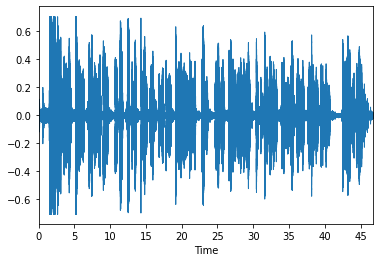

In [40]:
librosa.display.waveplot(wav, sr)

In [43]:
class CNN(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [46]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [182]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=64, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)

    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[2*sr:20*sr]
        spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                                            hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
        spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

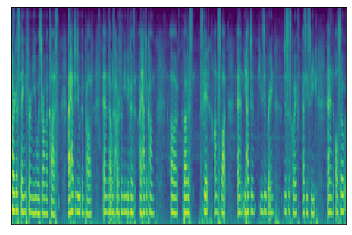

In [183]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)), cmap='viridis')

In [185]:
spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)).shape

(64, 563)

In [186]:
label_file = "C:/native_language/lab/ComParE2016_Nativeness.tsv"

In [187]:
data_file = pd.read_csv(label_file, sep="\t")
data_file.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [188]:
train_files = data_file['file_name'].str.contains('train')
train_df = data_file[train_files]
train_df.tail()

,file_name,promptId,L1
3295,train_3296.wav,P1,TEL
3296,train_3297.wav,P2,TUR
3297,train_3298.wav,P7,SPA
3298,train_3299.wav,P1,CHI
3299,train_3300.wav,P5,KOR


In [189]:
dev_files = data_file['file_name'].str.contains('devel')
dev_df = data_file[dev_files]
dev_df.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [190]:
len(train_df), len(dev_df)

(3300, 965)

In [192]:
class Data(Dataset):
    def __init__(self, df, base='C:/native_language/wav/', in_col='file_name', out_col='L1'):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category

        for ind in range(len(df)):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            label = row[out_col]
            self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row[out_col]])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [193]:
train_data = Data(train_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [194]:
dev_data = Data(dev_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [195]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(dev_data, batch_size=16, shuffle=True)

In [196]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [197]:
model = CNN(input_shape=(1, 64, 563), batch_size=16, num_cats=11).to(device)

In [198]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [199]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
train_losses = []
valid_losses = []

In [200]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    for epoch in range(1,epochs+1):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1]):.3f} Valid-Accuracy : {accuracy:.3f}')

In [201]:
def lr_decay(optimizer, epoch):
    if epoch%20==0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.448769175488016
Epoch - 1 Valid-Loss : 2.362847468892082 Valid-Accuracy : 0.138860103626943
Epoch - 2 Train-Loss : 2.3403638411259307
Epoch - 2 Valid-Loss : 2.2955017402523854 Valid-Accuracy : 0.19067357512953367
Epoch - 3 Train-Loss : 2.25752570087783
Epoch - 3 Valid-Loss : 2.2660282947978034 Valid-Accuracy : 0.18238341968911917
Epoch - 4 Train-Loss : 2.1497001601877996
Epoch - 4 Valid-Loss : 2.193418035741712 Valid-Accuracy : 0.23730569948186528
Epoch - 5 Train-Loss : 2.0113219846273966
Epoch - 5 Valid-Loss : 2.1888855988862086 Valid-Accuracy : 0.1927461139896373
Epoch - 6 Train-Loss : 1.8287002084335844
Epoch - 6 Valid-Loss : 2.1963393844541956 Valid-Accuracy : 0.21347150259067357
Epoch - 7 Train-Loss : 1.6674026728828173
Epoch - 7 Valid-Loss : 2.117433252881785 Valid-Accuracy : 0.21450777202072538
Epoch - 8 Train-Loss : 1.4376173313113227
Epoch - 8 Valid-Loss : 2.1540335338623797 Valid-Accuracy : 0.22383419689119172
Epoch - 9 Train-Loss : 1.2223191978274912

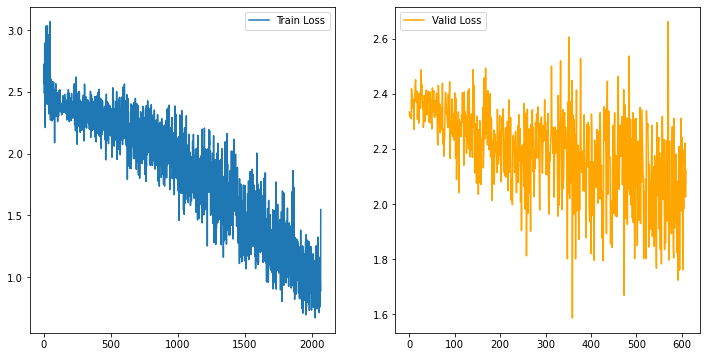

In [202]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [210]:
from sklearn.metrics import confusion_matrix

In [217]:
len(train_data.data)

3300

In [215]:
out = model(train_data.data)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

In [211]:
confusion_matrix(model, train_data.data, train_data.labels)

C:\Users\Alberto\anaconda3\envs\native-language-identification\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[6, 2, 8, 8, 4, 5, 0, 7, 4, 9, 7, 3, 1, 2, 4, 7, 8, 9, 10, 8, 0, 8, 3, 4, 9, 1, 3, 3, 6, 3, 10, 4, 10, 8, 8, 2, 9, 10, 2, 5, 6, 10, 10, 8, 6, 4, 1, 7, 10, 5, 5, 2, 7, 1, 6, 3, 10, 10, 6, 0, 6, 5, 3, 8, 9, 3, 3, 3, 0, 2, 6, 10, 9, 0, 1, 1, 9, 10, 5, 4, 0, 2, 2, 0, 2, 9, 7, 8, 1, 1, 5, 7, 3, 10, 9, 1, 7, 7, 0, 2, 6, 4, 7, 1, 0, 1, 8, 0, 8, 1, 1, 7, 5, 5, 3, 2, 2, 0, 5, 7, 9, 4, 9, 3, 1, 8, 6, 0, 10, 0, 3, 8, 4, 4, 10, 10, 10, 4, 10, 8, 0, 6, 7, 5, 8, 9, 9, 1, 2, 4, 6, 10, 4, 9, 9, 1, 0, 1, 5, 8, 1, 6, 5, 6, 0, 1, 8, 7, 2, 5, 6, 7, 9, 9, 7, 7, 3, 0, 9, 10, 0, 5, 8, 3, 8, 9, 6, 5, 6, 5, 8, 5, 10, 8, 10, 9, 5, 9, 7, 10, 2, 2, 0, 6, 5, 0, 6, 2, 5, 9, 4, 3, 0, 10, 10, 4, 9, 10, 1, 10, 8, 4, 10, 5, 10, 4, 10, 9, 8, 5, 2, 4, 8, 4, 0, 2, 9, 7, 5, 5, 0, 1, 6, 1, 8, 1, 3, 3, 4, 4, 8, 3, 9, 9, 7, 4, 2, 10, 8, 6, 1, 4, 0, 8, 10, 0, 6, 10, 1, 10, 10, 10, 10, 8, 9

TypeError: Expected sequence or array-like, got <class '__main__.CNN'>